# Mindful Business Focused Solution


- ++ feature engineering
- ++ base model: LightGBM
- ++ feature selection
- ++ benchmark model: Linear Regression
- ++ Two Layer Neural Network



In [1]:
# pipelines/smart_pandas.py

import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from sklearn.pipeline import FeatureUnion, _fit_transform_one, _transform_one
from scipy import sparse

class PandasFeatureUnion(FeatureUnion):
    """
    PandasFeatureUnion inherit from sklearn FeatureUnion to create a pipeline \
for feature engineering that return pandas.DataFrame.
    """

    def fit_transform(self, X, y=None, **fit_params):
        self._validate_transformers()
        result = Parallel(n_jobs=self.n_jobs)(
            delayed(_fit_transform_one)(
                transformer=trans, X=X, y=y, weight=weight, **fit_params
            )
            for name, trans, weight in self._iter()
        )

        if not result:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        Xs, transformers = zip(*result)
        self._update_transformer_list(transformers)
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

    def merge_dataframes_by_column(self, Xs):
        return pd.concat(Xs, axis="columns", copy=False)

    def transform(self, X):
        Xs = Parallel(n_jobs=self.n_jobs)(
            delayed(_transform_one)(transformer=trans, X=X, y=None, weight=weight)
            for name, trans, weight in self._iter()
        )
        if not Xs:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs


In [2]:
# pipelines/base_estimators.py
import pandas as pd

class CustomBase:
    
    def __init__(self, verbose=False):
        self.verbose = verbose
        
    def data_info(self, data:pd.DataFrame, sorted:bool=False) -> pd.DataFrame:
        """
        Function to describe the variables of a dataframe
        Analogous to the .describe() method of pandas.DataFrame
        """
        df = pd.DataFrame(pd.Series(data.columns))
        df.columns = ["columna"]
        df["NaNs"] = data.isna().sum().values
        df["pct_nan"] = round(df["NaNs"] / data.shape[0] * 100, 2)
        df["dtype"] = data.dtypes.values
        df["count"] = data.count().values
        df["count_unique"] = [
            len(data[elemento].value_counts()) for elemento in data.columns
        ]
        df["pct_unique"] = (df["count_unique"].values / data.shape[0] * 100).round(2)
        if sorted:
            df = df.reset_index(drop=False)
            df = df.sort_values(by=["dtype", "count_unique"])
        df = df.reset_index(drop=True)
        return df


In [3]:
# pipelines/estimators.py

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
import pickle
import datetime as dt

# import sys, os
# sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))
# from pipelines.base_estimators import CustomBase

class CorrectOutliers(BaseEstimator, TransformerMixin):
    def __init__(self, verbose=False):
        self.verbose = verbose
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_encoded = X.copy()
        X_encoded["DAYS_EMPLOYED"] = X["DAYS_EMPLOYED"].replace({365243: np.nan})
        return X_encoded
    
class CustomOrdinalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.encoder = OrdinalEncoder(
            handle_unknown="use_encoded_value",
            unknown_value=np.nan
            )
    
    def fit(self, X, y=None):
        self.X_ = X.copy()
        self.encoder.fit(self.X_[self.columns])
        return self
    
    def transform(self, X):
        X_encoded = X.copy()
        X_encoded = self.encoder.transform(X_encoded[self.columns])
        X_encoded = pd.DataFrame(X_encoded, columns=self.columns)
        return X_encoded
    
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.columns_= None
        self.encoder = OneHotEncoder(
            handle_unknown="ignore",
            sparse_output=False
            )
    
    def fit(self, X, y=None):
        self.X_ = X.copy()
        self.encoder.fit(self.X_[self.columns])
        return self
    
    def transform(self, X):
        X_encoded = X.copy()
        X_encoded = self.encoder.transform(X_encoded[self.columns])
        X_encoded = self.feature_adjust(X_encoded)
        self.columns_ = X_encoded.columns
        return X_encoded
    
    def feature_adjust(self, X_encoded):
        result = pd.DataFrame()
        last_len = 0
        for i, features in enumerate(self.encoder.categories_):
            len_feature = len(features)
            formated_features = [
                f"{self.columns[i]}_{feat}".replace(
                    " ", "_"
                )
                for feat in features
            ]
            builded_features = pd.DataFrame(
                X_encoded[:, last_len : last_len + len_feature],
                columns=formated_features,
            )
            result = pd.concat([result, builded_features], axis=1)
            last_len += len_feature
            
        result.columns = result.columns.str.replace(r"[^\w\s]", "_", regex=True).str.replace("__+", "_", regex=True)
        return result
        
class CustomImputer(BaseEstimator, TransformerMixin, CustomBase):
    def __init__(self, strategy="median"):
        self.strategy = strategy
        self.imputer = SimpleImputer(
            missing_values=np.nan,
            strategy=self.strategy)

    def fit(self, X, y=None):
        self.X_ = X.copy()
        self.imputer.fit(X)
        return self

    def transform(self, X):
        X_encoded = X.copy()
        X_encoded = self.imputer.transform(X_encoded)
        
        # Create DataFrame and correct columns types
        X_encoded = pd.DataFrame(X_encoded, columns=self.X_.columns)
        X_info = self.data_info(self.X_)
        X_dtypes = X_info.set_index("columna")["dtype"].to_dict()
        X_encoded = X_encoded.astype(X_dtypes)
        
        return X_encoded
        
class CustomBackup(BaseEstimator, TransformerMixin):
    def __init__(self, shutdown=False):
        self.shutdown = shutdown
    
    def fit(self, X, y=None):
        self.X_ = X.copy()
        return self
    
    def transform(self, X):#TODO: df.name para identificar train, val, test 
        if self.shutdown:
            return X
        dm = dt.datetime.now().strftime("%d_%m")
        hms = dt.datetime.now().strftime("%H_%M_%S")
        with open(f"data-{dm}-{hms}-backup.pkl", "wb") as f:
            pickle.dump(X, f)
        # try:#Warning: X.name is not detected
        #     #Warning: downloading .csv have some issues downloading more than 1 file
        #     file_name = f"{X.name}-{dm}-{hms}-backup.csv"
        # except:
        #     file_name = f"data-{dm}-{hms}-backup.csv"
        # X.to_csv(file_name, index=False)
        return X
    
class CustomDropna(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        self.X_ = X.copy()
        return self
    
    def transform(self, X):
        X_encoded = X.copy()
        X_encoded = X_encoded.loc[:, [not col.endswith("nan") for col in X_encoded.columns]]
        return X_encoded
    
class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self, scaler=MinMaxScaler):
        self.scaler = scaler()
    
    def fit(self, X, y=None):
        self.X_ = X.copy()
        self.scaler.fit(self.X_)
        return self
    
    def transform(self, X):
        X_encoded = X.copy()
        X_encoded = self.scaler.transform(X_encoded)
        X_encoded = pd.DataFrame(X_encoded, columns=self.X_.columns)
        return X_encoded
    

In [4]:
# pipelines/lgbm_estimator.py

import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin


class LGBMEstimator(BaseEstimator, TransformerMixin):
    def __init__(self, params, val_data, y_val):
        self.params = params
        self.val_data = val_data
        self.y_val = y_val
        self.model = lgb
        
    def fit(self, X, y=None):
        self.X_ = X.copy() 
        self.y_= y.copy()
        self.train_set = lgb.Dataset(self.X_, label=self.y_)
        self.val_set = lgb.Dataset(self.val_data, label=self.y_val)
        self.model = self.model.train(self.params, self.train_set, num_boost_round=1000, callbacks=[lgb.early_stopping(100)], valid_sets=[self.train_set, self.val_set])
        return self
    
    def predict(self, X):
        X_ = X.copy()
        predictions = self.model.predict(X_)
        return predictions
    
    def score(self, X, y=None):
        y_pred = self.predict(X)
        return roc_auc_score(y_true=y, y_score=y_pred)

In [5]:
# main_pipeline.py

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler

from src import data_utils
# from pipelines.estimators import CorrectOutliers, CustomOrdinalEncoder, CustomOneHotEncoder, CustomImputer, CustomBackup, CustomScaler, CustomDropna
# from pipelines.smart_pandas import PandasFeatureUnion


app_train, app_test, columns_description = data_utils.get_datasets()
X_train, y_train, X_test, y_test = data_utils.get_feature_target(app_train, app_test)
X_train, X_val, y_train, y_val = data_utils.get_train_val_sets(X_train, y_train)

dtype_object_info = (X_train.loc[:, (X_train.dtypes == "object").values]
        .apply(lambda x: x.to_frame().drop_duplicates().value_counts(), axis=0)
        .sum())

assert isinstance(dtype_object_info, pd.core.series.Series), "type error"


# Numerical or Datetime features
num_dt_ft = X_train.loc[:, (X_train.dtypes != "object").values].columns.tolist()
# Object type features with two unique categories
two_cat_ft = dtype_object_info[dtype_object_info == 2].index.to_list()
# Object type features with more than two unique categories
plus_two_cat_ft = dtype_object_info[dtype_object_info > 2].index.to_list()


workflow_1 = PandasFeatureUnion([
    ("num_dt_cat", FunctionTransformer(lambda X: X[num_dt_ft].reset_index())),
    ("binary_cat", CustomOrdinalEncoder(two_cat_ft)),
    ("multi_label_cat", CustomOneHotEncoder(plus_two_cat_ft)),
    ])

feature_enginering = Pipeline([
    ("outliers", CorrectOutliers(verbose=True)),
    ("numerical_transformation", workflow_1),
    ("impute_nan", CustomImputer(strategy="median")),
    ("backup", CustomBackup()),
    ("remove_nan", CustomDropna()),
    ("scale", CustomScaler(scaler=StandardScaler)),
    ])

feature_enginering.fit(X_train)
train_data = feature_enginering.transform(X_train)
val_data = feature_enginering.transform(X_val)
test_data = feature_enginering.transform(X_test)
feature_enginering.set_params(backup__shutdown=True)


params = {
    "objective": "binary",
    "metric": "auc",
    "min_child_samples": 2000,
    "num_leaves": 14,
    "learning_rate": 0.1,
    "random_state": 88,
    "n_jobs": -1,
    "verbose": 0,
}

base_model_pipeline = Pipeline([
    ("feature_enginering", feature_enginering),
    ("model", LGBMEstimator(params=params, val_data=val_data, y_val=y_val)),
])

base_model_pipeline.fit(X_train, y_train)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[190]	training's auc: 0.785487	valid_1's auc: 0.754192


Pipeline(steps=[('feature_enginering',
                 Pipeline(steps=[('outliers', CorrectOutliers(verbose=True)),
                                 ('numerical_transformation',
                                  PandasFeatureUnion(transformer_list=[('num_dt_cat',
                                                                        FunctionTransformer(func=<function <lambda> at 0x0000022752A813A0>)),
                                                                       ('binary_cat',
                                                                        CustomOrdinalEncoder(columns=['NAME_CONTRACT_TYPE',
                                                                                                      'FLAG_OWN_CAR',
                                                                                                      'FLAG_OWN_REALTY',
                                                                                                      'EMERGENCY...
49199                 -0.523149                       -0.515420   
49200                 -0.523149                       -0.515420   
49201                 -0.523149                       -0.515420   

       WALLSMATERIAL_MODE_Wooden  
0                      -0.132568  
1                      -0.132568  
2                      -0.132568  
3                      -0.132568  
4                      -0.132568  
...                          ...  
49197                  -0.132568  
49198                  -0.132568  
49199                  -0.132568  
49200                  -0.132568  
49201                  -0.132568  

[49202 rows x 241 columns],
                               y_val=226655    0
183464    0
110628    0
181486    0
46437     0
         ..
226050    0
38757     0
91305     1
66491     0
54500     0
Name: TARGET, Length: 49202, dtype: int64))])

In [6]:
base_lgbm_model = base_model_pipeline.named_steps["model"].model


Train ROC AUC Score: 0.7855
Validation ROC AUC Score: 0.7542


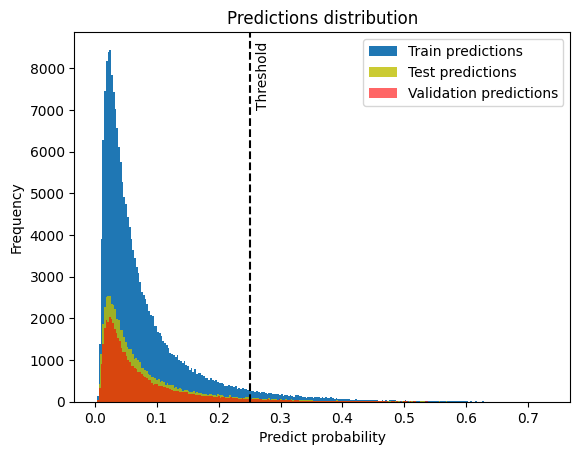

Test ROC AUC Score: 0.9849
Percentage difference Score (train - val): 3.1 %


In [7]:
train_predict_proba = base_model_pipeline.predict(X_train)
val_predict_proba = base_model_pipeline.predict(X_val)
test_predict_proba = base_model_pipeline.predict(X_test)

# Binarize Score
threshold = 0.25
train_predict = (train_predict_proba > threshold).astype(int)
val_predict = (val_predict_proba > threshold).astype(int)
test_predict = (test_predict_proba > threshold).astype(int)
y_test_real = (y_test > threshold).astype(int)

# ROC AUC Score
train_score = base_model_pipeline.score(X_train, y_train)
val_score = base_model_pipeline.score(X_val, y_val)
test_score = base_model_pipeline.score(X_test, y_test_real)
print()
print("Train ROC AUC Score: {:.4f}".format(train_score))
print("Validation ROC AUC Score: {:.4f}".format(val_score))

ax1 = pd.Series(train_predict_proba).plot(kind="hist", bins=255, alpha=1)
ax2 = pd.Series(test_predict_proba).plot(kind="hist", bins=255, alpha=0.8, color="y")
ax3 = pd.Series(val_predict_proba).plot(kind="hist", bins=255, alpha=0.6, color="r")
ax3.set_xlabel("Predict probability")
ax3.set_title("Predictions distribution")
ax3.legend(["Train predictions", "Test predictions", "Validation predictions"])
ax3.axvline(x=threshold, color="k", linestyle="--")
ax3.text(
    threshold + 0.01,
    7000,#  hardcoded
    "Threshold",
    rotation=90,
    verticalalignment="bottom",
    horizontalalignment="left",
    color="k",
    fontsize=10,
)
plt.show()


print("Test ROC AUC Score: {:.4f}".format(test_score))
diff = round((train_score - val_score) *100, 1)
print(f"Percentage difference Score (train - val): {diff} %")

# Feature Selection

In [8]:
base_lgbm_model = base_model_pipeline.named_steps["model"].model
relevant_features = base_lgbm_model.feature_importance() != 0

In [9]:
X = train_data.loc[:, relevant_features]
Y = y_train

X_val, Y_val = val_data.loc[:, relevant_features], y_val
X_test, Y_test = test_data.loc[:, relevant_features], y_test_real

In [10]:
# import a logistic regresion model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

log_reg = LogisticRegression(random_state=42, C=0.001).fit(X, Y)

log_reg_train = log_reg.predict_proba(X)[:, 1]
log_reg_val = log_reg.predict_proba(X_val)[:, 1]
log_reg_test = log_reg.predict_proba(X_test)[:, 1]

# Train ROC AUC Score
roc_auc_train = roc_auc_score(y_true=Y, y_score=log_reg_train)
roc_auc_val = roc_auc_score(y_true=Y_val, y_score=log_reg_val)
roc_auc_test = roc_auc_score(y_true=Y_test, y_score=log_reg_test)
print()
print(f"Train ROC AUC Score: {roc_auc_train:.4f}")
print(f"Validation ROC AUC Score: {roc_auc_val:.4f}")
print(f"Percentage difference Score (train - val): {round((roc_auc_train - roc_auc_val) *100, 1)} %")
print()
print("Test ROC AUC Score: {:.4f}".format(roc_auc_test))


Train ROC AUC Score: 0.7463
Validation ROC AUC Score: 0.7405
Percentage difference Score (train - val): 0.6 %

Test ROC AUC Score: 0.9850


# Two Layer Neural Network

In [11]:
# neural_network/activation_functions.py

import numpy as np

def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    """
    Implement the RELU function.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ


In [12]:
# neural_network/initialization.py

###  1.1 Inicializacion red de dos capas (1 hidden, 1 output) ###
def initialize_parameters(n_x: int, n_h: int, n_y: int) -> dict:
    """

    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    parameters -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(1)
    
    W1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h)*0.01
    b2 = np.zeros((n_y, 1))    
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters 

###  1.2 Inicializacion red de L capas ###
def initialize_parameters_deep(layer_dims: list) -> dict:
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters


In [13]:
# neural_network/forward_propagation.py

### 2.1 Implementación de linear forward ###
def linear_forward(A: np.array, W: np.array, b: np.array) -> tuple:
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python tuple containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    Z = np.dot(W, A) + b
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

### 2.2 Implementación de linear-activation forward ###
def linear_activation_forward(A_prev: np.array, W: np.array, b: np.array, activation: str) -> tuple:
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python tuple containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    # test for valid options
    assert activation == "sigmoid" or activation == "relu"
    
    # test for object type
    assert isinstance(A_prev, np.ndarray), "A_prev no es un np.ndarray"
    assert isinstance(W, np.ndarray), "W no es un np.ndarray"
    assert isinstance(b, np.ndarray), "b no es un np.ndarray"
    
    # test for shape
    assert A_prev.ndim == 2, "A_prev no es un rank 2 array"
    assert W.ndim == 2, "W no es un rank 2 array"
    assert b.ndim == 2, "b no es un rank 2 array"
    
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)        
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    cache = (linear_cache, activation_cache)

    return A, cache

###   2.3) Combinación de 2.1 y 2.2  ###
def L_model_forward(X: np.array, parameters: dict) -> tuple:
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- activation value from the output (last) layer
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L of them, indexed from 0 to L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2 #  number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(
            A_prev, parameters['W' + str(l)], parameters['b' + str(l)], 'relu'
            )
        caches.append(cache)        
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL , cache = linear_activation_forward(
        A, parameters['W' + str(L)], parameters['b' + str(L)], 'sigmoid'
        )
    caches.append(cache)    
          
    return AL, caches



In [14]:
# neural_network/cost_function.py

### 3) Función de costo  ###
### Para implementar la función de costo necesitamos un test set para comparar el valor de las predicciones
def compute_cost(AL: np.array, Y: np.array) -> float:
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    cost = -np.sum(np.multiply(Y, np.log(AL)) + np.multiply(1-Y, np.log(1-AL)))/m    
    
    cost = np.squeeze(cost) #  To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).

    return cost

In [15]:
# neural_network/backward_propagation.py

def linear_backward(dZ: np.array, cache: tuple) -> tuple:
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = np.dot(dZ, A_prev.T)/m
    db = np.sum(dZ, axis=1, keepdims=True)/m
    dA_prev = np.dot(W.T, dZ)    
    
    return dA_prev, dW, db


###    4.2) Completa la capa LINEAR-ACTIVATION hacia atrás    ###
###                 Linear-Activation-Backward                ###
def linear_activation_backward(dA: np.array, cache: tuple, activation: str) -> tuple:
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)        
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)        
    
    return dA_prev, dW, db

###    4.3) Implementanción de backward propagation L capas     ###
###                 Backward-Propagation                        ###
def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))    
    
    current_cache = caches[L-1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(
        dAL, current_cache, 'sigmoid'
        )
    grads["dA" + str(L-1)] = dA_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp    
    
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(
            grads["dA" + str(l+1)], current_cache, 'relu'
            )
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l+1)] = dW_temp
        grads["db" + str(l+1)] = db_temp        

    return grads


In [16]:
# neural_network/update_parameters.py
from copy import deepcopy

def update_parameters(params, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    params -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    parameters = deepcopy(params)
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads["db" + str(l+1)]       

    return parameters

In [59]:
# neural_network/model.py

def feed_exploration(X, Y, X_test, Y_test):

    X = X.to_numpy()#.reshape(X.shape[1], X.shape[0])
    Y = Y.to_numpy().reshape(Y.shape[1], Y.shape[0])
    X_test = X_test.to_numpy()
    Y_test = Y_test.to_numpy().reshape(Y_test.shape[1], Y_test.shape[0])
    
    # Explore your dataset 
    m_train = X.shape[0]
    num_px = X.shape[1]
    m_test = X_test.shape[0]

    print ("Number of training examples: " + str(m_train))
    print ("Number of testing examples: " + str(m_test))
    print ("train_x_orig shape: " + str(X.shape))
    print ("train_y shape: " + str(Y.shape))
    print ("test_x_orig shape: " + str(X_test.shape))
    print ("test_y shape: " + str(Y_test.shape))

    return X, Y, X_test, Y_test

def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        A1, cache1 = linear_activation_forward(X, W1, b1, 'relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2, 'sigmoid')
 
        # Compute cost
        cost = compute_cost(A2, Y)        
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, 'sigmoid')
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, 'relu')
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {:.4f}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)

    return parameters, costs

def predict(X, y, parameters, threshold=0.5):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > threshold:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: {:.4f}".format(np.sum((p == y)/m)))
        
    return p

def predict_proba(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)
          
    return probas[0]

In [18]:
## MAIN ## MAIN ## MAIN ## MAIN ## MAIN ## MAIN ## MAIN ##

X, Y, X_test, Y_test = feed_exploration(X, Y.to_frame(), X_val, Y_val.to_frame())



Number of training examples: 196806
Number of testing examples: 49202
train_x_orig shape: (196806, 127)
train_y shape: (1, 196806)
test_x_orig shape: (49202, 127)
test_y shape: (1, 49202)


In [19]:
train_x_flatten = np.array(X, dtype=np.float64)
test_x_flatten = np.array(X_test, dtype=np.float64)
train_x_flatten = train_x_flatten.reshape(train_x_flatten.shape[0], -1).T
test_x_flatten = test_x_flatten.reshape(test_x_flatten.shape[0], -1).T

In [20]:
test_x_flatten

array([[ 1.45871144,  0.85052375, -0.17510563, ..., -0.4471996 ,
        -0.79661428, -0.96546377],
       [ 1.43458341,  0.24071893,  0.13136347, ..., -1.26158379,
         1.21917949,  0.64603351],
       [-0.57910809, -0.57910809, -0.57910809, ...,  0.80443278,
        -0.57910809, -0.57910809],
       ...,
       [-0.97720157,  1.02333032,  1.02333032, ..., -0.97720157,
        -0.97720157, -0.97720157],
       [-0.52314921, -0.52314921, -0.52314921, ..., -0.52314921,
        -0.52314921, -0.52314921],
       [-0.51542008,  1.940165  ,  1.940165  , ..., -0.51542008,
        -0.51542008, -0.51542008]])

In [61]:
###  Hiperparámetros del modelo  ###

n_x = X.shape[1] # numero de input features
n_h = n_x # numero de neuronas en la capa oculta
n_y = 1 # numero de neuronas en la capa de salida

learning_rate = 0.3
num_iterations = 750

### ENTRENAMIENTO ###
parameters, costs = two_layer_model(
    train_x_flatten, Y, 
    layers_dims = (n_x, n_h, n_y), 
    num_iterations = num_iterations,
    learning_rate = learning_rate,
    print_cost=False
    )

# Last Execution: 16m 44s -> Cost after iteration 1499 0.2481
# Last Execution: 4m 19s ->  Cost after iteration 399: 0.2540
# Last Execution: 6m 34s ->  Cost after iteration 599: 0.2505 (a: 0.12)
# Last Execution: 6m 16s ->  Cost after iteration 599: 0.2492 (a: 0.18)
# Last Execution: 6m 16s ->  Cost after iteration 599: 0.2486 (a: 0.22)
# Last Execution: 7m 20s ->  Cost after iteration 699: 0.2477 (a: 0.25) # Benchmark
# Last Execution: 7m 48s ->  Cost after iteration 749: 0.2475 (a: 0.25) 
# Last Execution: 7m 48s ->  Cost after iteration 749: 0.2469 (a: 0.3) # Final

Cost after iteration 749: 0.2469


In [84]:
import pickle
with open('parameters.pkl', 'wb') as f:
    pickle.dump(parameters, f)
with open('costs.pkl', 'wb') as f:
    pickle.dump(costs, f)

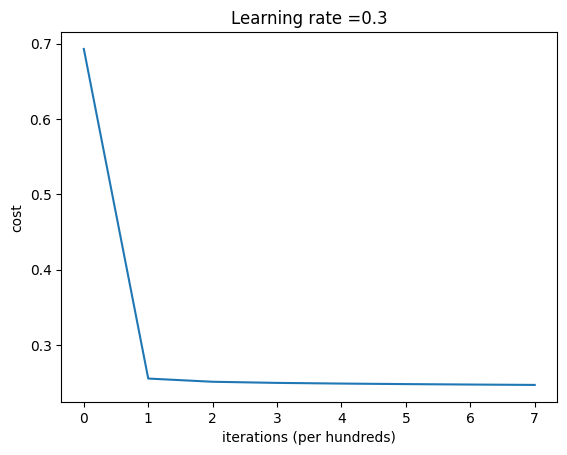

In [ ]:
# plot costs
def plot_costs(costs, learning_rate=0.0075):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
plot_costs(costs, learning_rate)

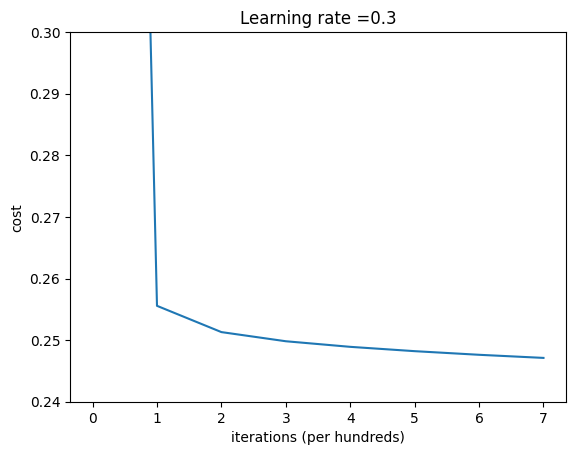

In [83]:
# plot costs
def plot_costs(costs, learning_rate=0.0075, y_min=0.24, y_max=None):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    
    if y_min is not None and y_max is not None:
        plt.ylim(y_min, y_max)
    
    plt.show()
    
plot_costs(costs, learning_rate, y_max=0.3)

In [85]:
print("Train score:")
predictions_train = predict(train_x_flatten, Y, parameters, threshold=threshold)

print("Test score (val):")
predictions_test = predict(test_x_flatten, Y_test, parameters, threshold=threshold)

Train score:
Accuracy: 0.9172
Test score (val):
Accuracy: 0.9141


In [86]:
train_proba = predict_proba(test_x_flatten, Y_test, parameters)
test_proba = predict_proba(test_x_flatten, Y_test, parameters)

<AxesSubplot: ylabel='Frequency'>

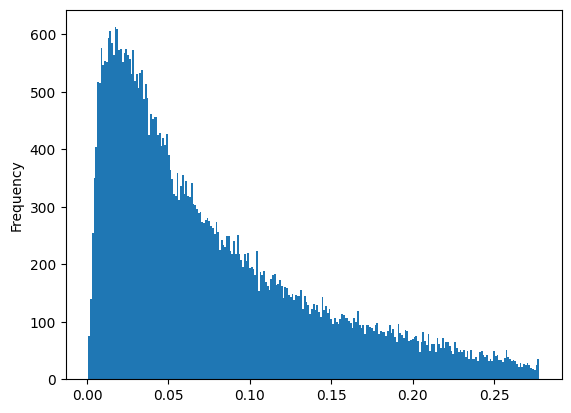

In [87]:
pd.Series(train_proba).plot(kind="hist", bins=255, alpha=1)

In [89]:
# ROC AUC Score
# try:
#     train_score = roc_auc_score(y_true=Y, y_score=train_proba)
#     test_score = roc_auc_score(y_true=Y_test, y_score=test_proba)
#     print()
#     print("Train ROC AUC Score: {:.4f}".format(train_score))
#     print("Test ROC AUC Score: {:.4f}".format(test_score))
# except:
#     print("There are only one class in the target variable")

train_score = roc_auc_score(y_true=Y.T, y_score=train_proba)
test_score = roc_auc_score(y_true=Y_test, y_score=test_proba)
print()
print("Train ROC AUC Score: {:.4f}".format(train_score))
print("Test ROC AUC Score: {:.4f}".format(test_score))


ValueError: Found input variables with inconsistent numbers of samples: [196806, 49202]

In [53]:
train_proba

vc_train = pd.Series(Y[0]).value_counts()
vc_test = pd.Series(Y_test[0]).value_counts()

vc_train_pct = (vc_train / vc_train.sum()) *100
vc_test_pct = (vc_test / vc_test.sum()) *100

print(f"Percentage Value Counts Train: \n{round(vc_train_pct, 1)} %")
print(f"Percentage Value Counts Test: \n{round(vc_test_pct, 1)} %")

Percentage Value Counts Train: 
0    92.0
1     8.0
dtype: float64 %
Percentage Value Counts Test: 
0    91.8
1     8.2
dtype: float64 %


# Predictions

In [ ]:
import pickle

with open("data-15_12-15_56_42-backup.pkl", "rb") as f:
    real_data = pickle.load(f)
real_data

,index,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,HOUSETYPE_MODE_terraced_house,HOUSETYPE_MODE_nan,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,WALLSMATERIAL_MODE_Stone_brick,WALLSMATERIAL_MODE_Wooden,WALLSMATERIAL_MODE_nan
0,0,138399,0,202500.0,495216.0,30055.5,427500.0,0.030755,-12142,-2851.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,263198,0,225000.0,675000.0,19863.0,675000.0,0.014520,-13619,-6391.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2,114902,0,103500.0,327024.0,18391.5,270000.0,0.025164,-19763,-253.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,3,408795,4,225000.0,284400.0,13387.5,225000.0,0.010500,-13348,-1897.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,282313,0,157500.0,1125000.0,32895.0,1125000.0,0.026392,-17762,-2805.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61498,61498,413713,0,90000.0,845811.0,35964.0,756000.0,0.035792,-22322,-1649.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
61499,61499,342304,1,157500.0,247500.0,12375.0,247500.0,0.031329,-15179,-8501.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
61500,61500,235580,0,202500.0,450000.0,22860.0,450000.0,0.011703,-9912,-416.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
61501,61501,259162,3,180000.0,418743.0,25749.0,342000.0,0.020713,-14376,-7179.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# Data Treatment

real_data = CustomDropna().fit_transform(real_data)
real_data = real_data.loc[:, relevant_features]
real_data

,index,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,ORGANIZATION_TYPE_Industry_type_3,ORGANIZATION_TYPE_Industry_type_9,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Self_employed,ORGANIZATION_TYPE_Trade_type_3,ORGANIZATION_TYPE_Trade_type_7,HOUSETYPE_MODE_block_of_flats,WALLSMATERIAL_MODE_Panel,WALLSMATERIAL_MODE_Stone_brick
0,0,138399,0,202500.0,495216.0,30055.5,427500.0,0.030755,-12142,-2851.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,263198,0,225000.0,675000.0,19863.0,675000.0,0.014520,-13619,-6391.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,114902,0,103500.0,327024.0,18391.5,270000.0,0.025164,-19763,-253.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,3,408795,4,225000.0,284400.0,13387.5,225000.0,0.010500,-13348,-1897.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,4,282313,0,157500.0,1125000.0,32895.0,1125000.0,0.026392,-17762,-2805.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61498,61498,413713,0,90000.0,845811.0,35964.0,756000.0,0.035792,-22322,-1649.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61499,61499,342304,1,157500.0,247500.0,12375.0,247500.0,0.031329,-15179,-8501.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
61500,61500,235580,0,202500.0,450000.0,22860.0,450000.0,0.011703,-9912,-416.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
61501,61501,259162,3,180000.0,418743.0,25749.0,342000.0,0.020713,-14376,-7179.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
real_data.to_numpy().shape

(61503, 127)

In [ ]:
# Data Preparation
real_x_flatten = np.array(real_data.to_numpy(), dtype=np.float64)
real_x_flatten = real_x_flatten.reshape(real_x_flatten.shape[0], -1).T
real_x_flatten.shape

(127, 61503)

In [ ]:
# Prediction

real_proba = predict_proba(real_x_flatten, Y_test, parameters)
real_predict = (real_proba > threshold).astype(int)

C:\Users\Agustin\AppData\Local\Temp\ipykernel_8744\1142176721.py:17: RuntimeWarning: overflow encountered in exp
  A = 1/(1+np.exp(-Z))


In [ ]:
# ROC AUC Score
real_score = roc_auc_score(y_true=y_test_real, y_score=real_proba)

print()
print("Real ROC AUC Score: {:.4f}".format(real_score))



Real ROC AUC Score: 0.5000


In [ ]:
pd.Series(real_predict).value_counts()

0    61503
dtype: int64